In [1]:
# 데이터 시각화
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

# 로지스틱 회귀로 와인 분류하기

In [2]:
import pandas as pd

In [4]:
wine = pd.read_csv('../data/wine.csv')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [6]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [8]:
wine.isnull().sum()

alcohol    0
sugar      0
pH         0
class      0
dtype: int64

In [11]:
# class의 종류
wine['class'].unique()

array([0., 1.])

> 0 : red wine, 1 : white wine

In [13]:
# 기본 통계량
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [14]:
# Dimension
wine.shape

(6497, 4)

---
## Feature와 Target으로 Data 분리

In [15]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [16]:
### Train, Test 분리
from sklearn.model_selection import train_test_split

In [17]:
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42
)

In [18]:
# Train, Test 크기 확인
print('Train :', train_input.shape)
print('Test :', test_input.shape)

Train : (5197, 3)
Test : (1300, 3)


### 정규화하기, 로지스틱 회귀

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
ss = StandardScaler().fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

### 로지스틱 회귀 모델 실행

In [21]:
from sklearn.linear_model import LogisticRegression

In [23]:
lr = LogisticRegression().fit(train_scaled, train_target)
print('train score :', lr.score(train_scaled, train_target))
print('test score :', lr.score(test_scaled, test_target))

train score : 0.7808350971714451
test score : 0.7776923076923077


In [24]:
# 가중치와 편차
print(lr.coef_, lr.intercept_)

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


class = 0.51270274 * alcohol + 1.6733911 * sugar + (-0.68767781 * pH) + 1.81777902   
> sugar가 가장 큰 가중치

---
### 결정트리, Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
dt = DecisionTreeClassifier(random_state=42).fit(train_scaled, train_target)
print('train score :', dt.score(train_scaled, train_target))
print('test score :', dt.score(test_scaled, test_target))

train score : 0.996921300750433
test score : 0.8592307692307692


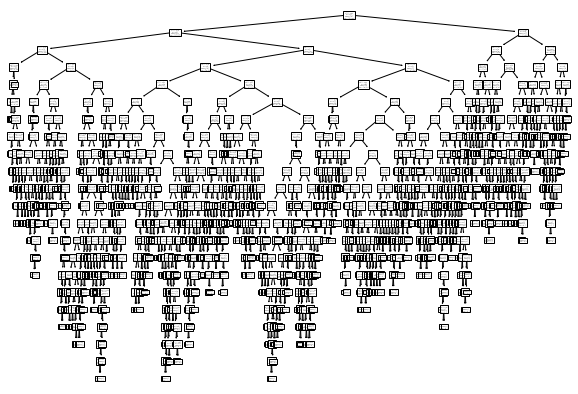

In [27]:
# 시각화
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 7))

plot_tree(dt)

plt.show()

> 맨 위의 단계를 'root node'라 하고 마지막 단계는 'leaf node'라 한다.   
> 시간이 많이 걸리고 단계가 너~무 복잡하다.   
> 규제를 준다, '가지치기' 한다.

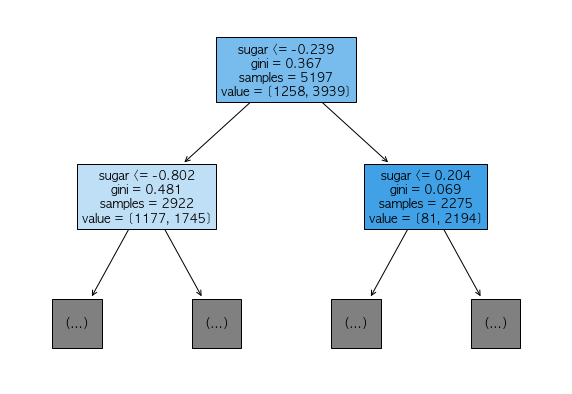

In [30]:
# decision tree의 단계(depth)를 단순하게 하자
plt.figure(figsize=(10,7))

plot_tree(
    dt, max_depth=1, 
    filled=True, # 색 채우기
    feature_names=['alcohol', 'sugar', 'pH']
    )

plt.show()

> sugar가 제일 결정력이 좋으니 그걸 기준으로 가지를 뻗어나간다.   
> 왼쪽 가지가 Yes 오른쪽 가지가 No   
> gini 계수가 중요하다. 불순도가 0이 될 때까지 가지를 뻗어나간다.   

### 지니 불순도, Gini impurity
지니 불순도가 0이 나올 때를 순수노드라고 한다.   
리프노드가 순수노드인 것이 좋으나, 이 때문에 과대적합이 발생한다.   
따라서 적절한 max_depth를 찾는 것이 중요하다.

In [33]:
1 - ((1258 / 5197)**2 + (3939 / 5197)**2)

0.3669367279393918

# 가지치기(Tree Pruning)
- max_depth의 parameter 값을 조절
- decision tree에서 과대적합을 막는다.
- L1, L2 규제를 사용할 수 없다. (L1, L2는 회귀식 전용)

In [34]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42).fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


> max_depth를 조정했더니 차이가 줄어들었다.

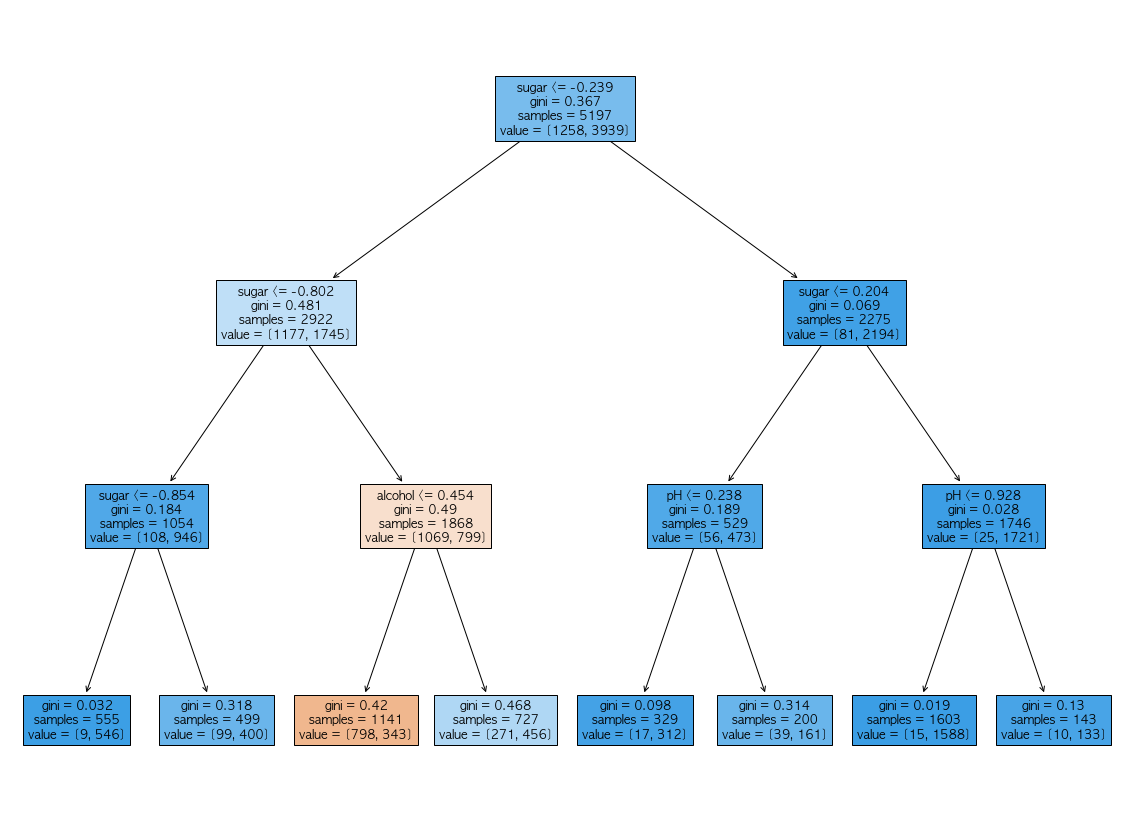

In [35]:
# 시각화
plt.figure(figsize=(20, 15))

plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])

plt.show()

> 레드 와인은 value의 좌측항이 크고, 화이트 와인은 우측항이 크다.   
> 처음엔 sugar로 나중엔 pH, alcohol로 분류한다.

In [36]:
# 특성 중요도
dt.feature_importances_

array([0.12345626, 0.86862934, 0.0079144 ])

---
### 최적화시키기

In [37]:
# 불순도가 0이 아니라 0.0005
dt = DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42).fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8874350586877044
0.8615384615384616


> scaled와 input이 똑같아서 그냥 사용

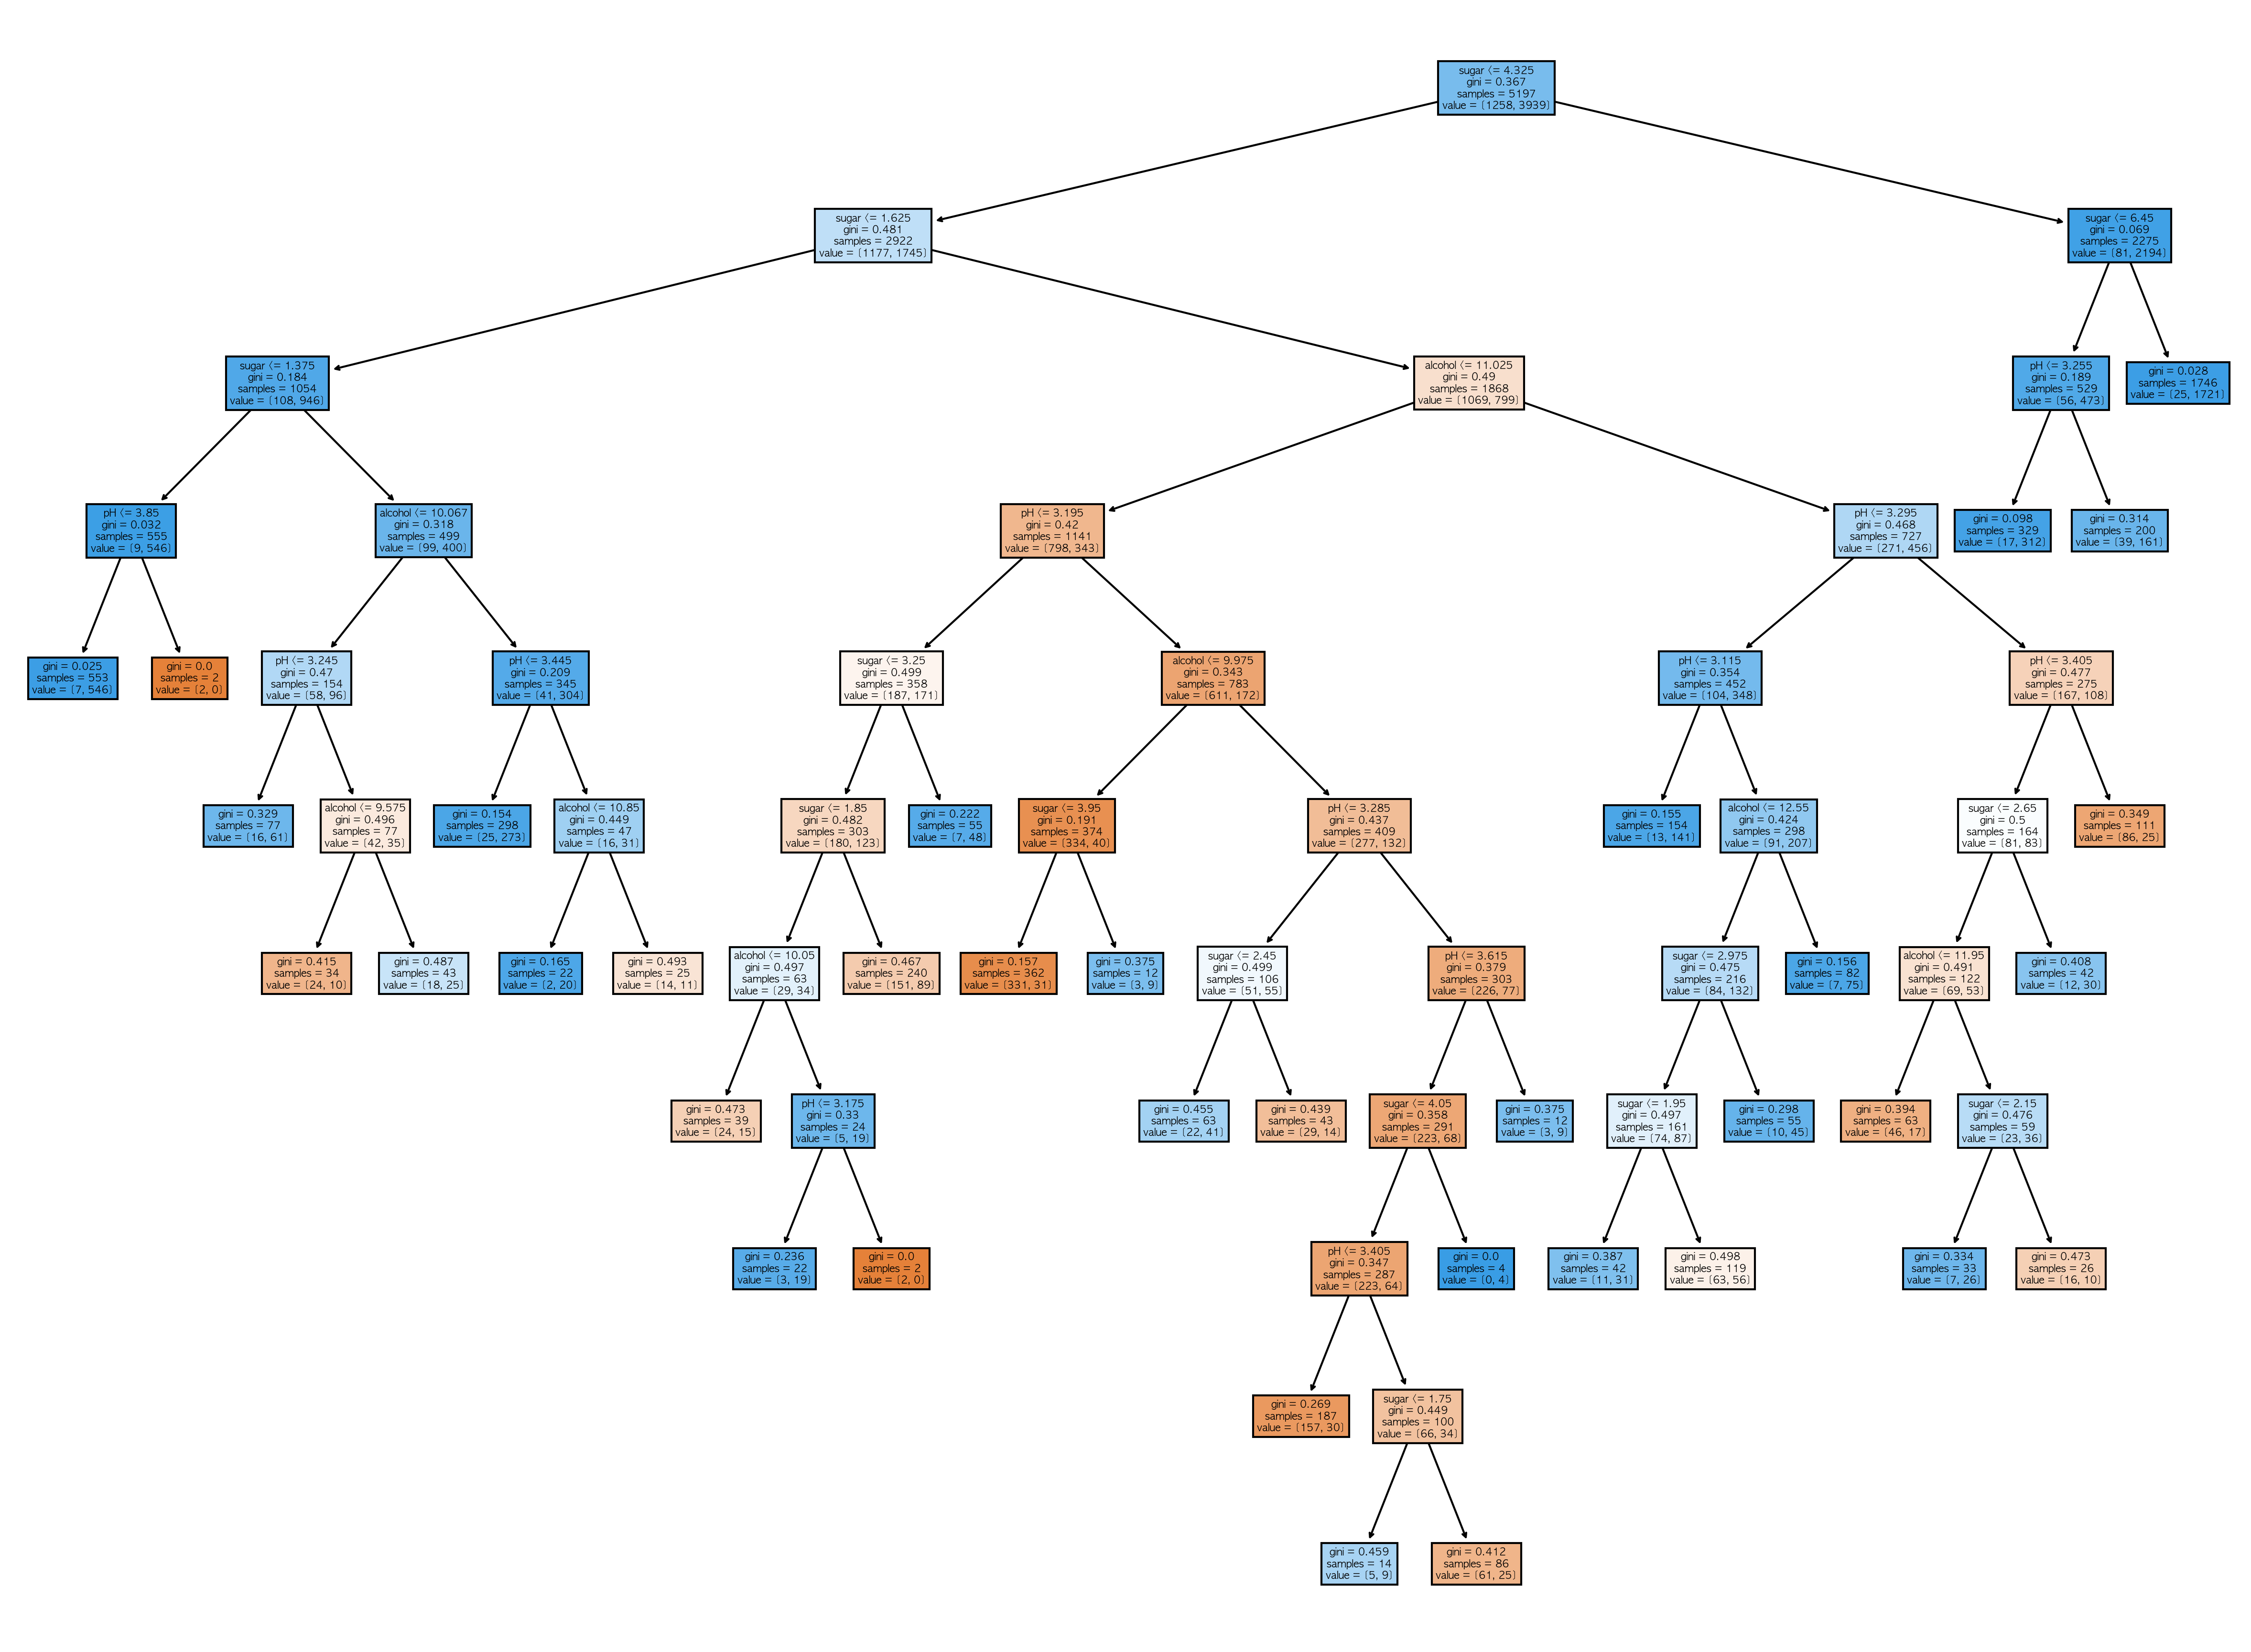

In [38]:
# 시각화하기
plt.figure(figsize=(20, 15), dpi=300) # dpi : dot per inch

plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.savefig('../data/wine.jpg')

plt.show()